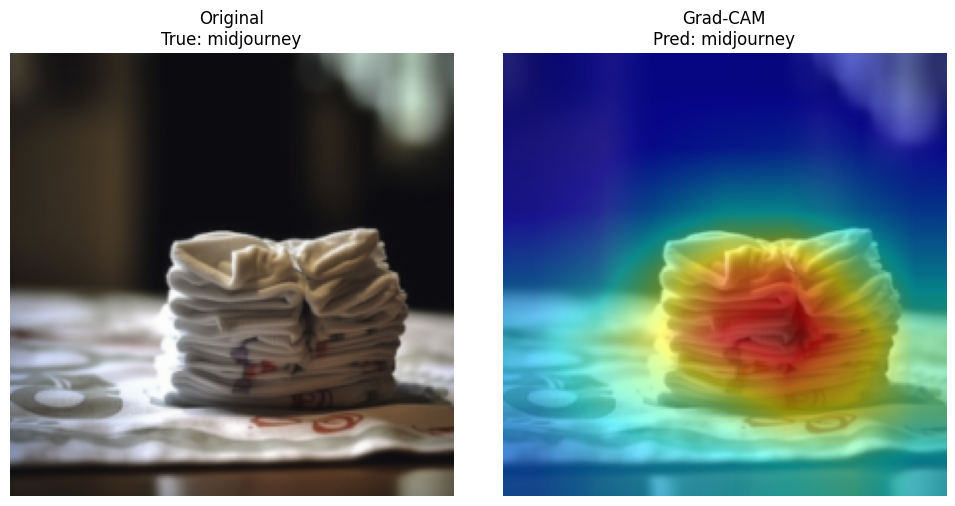

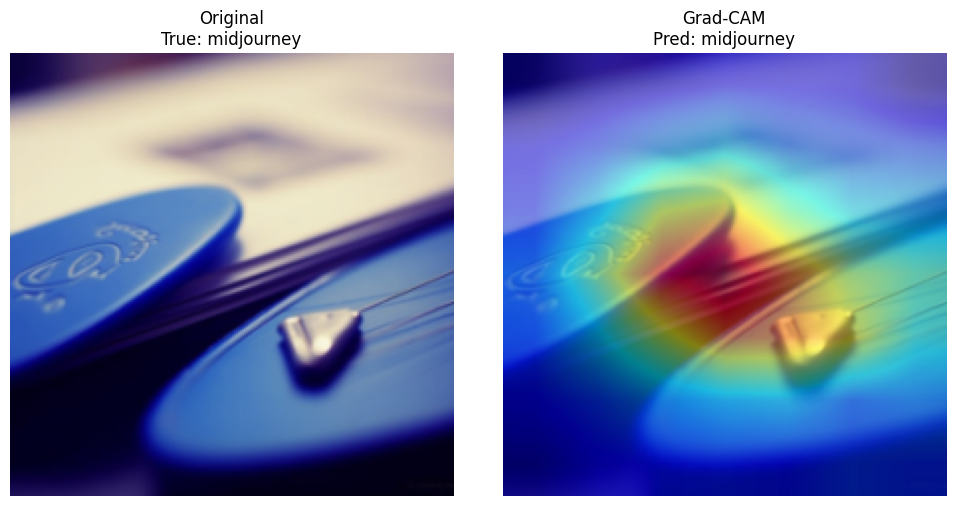

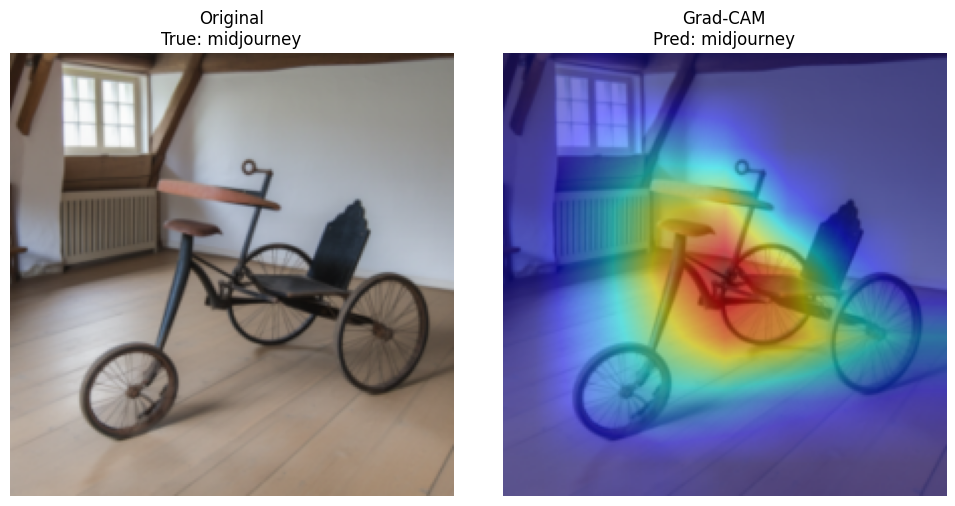

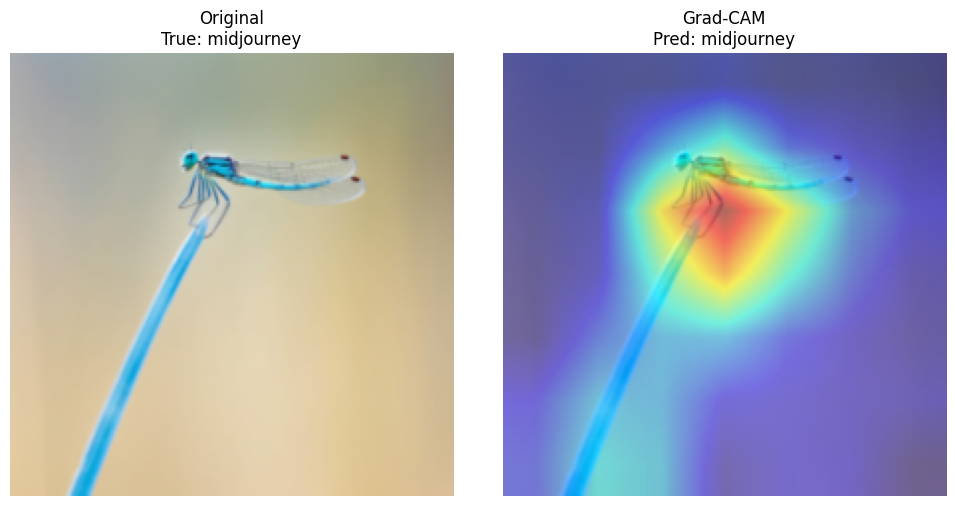

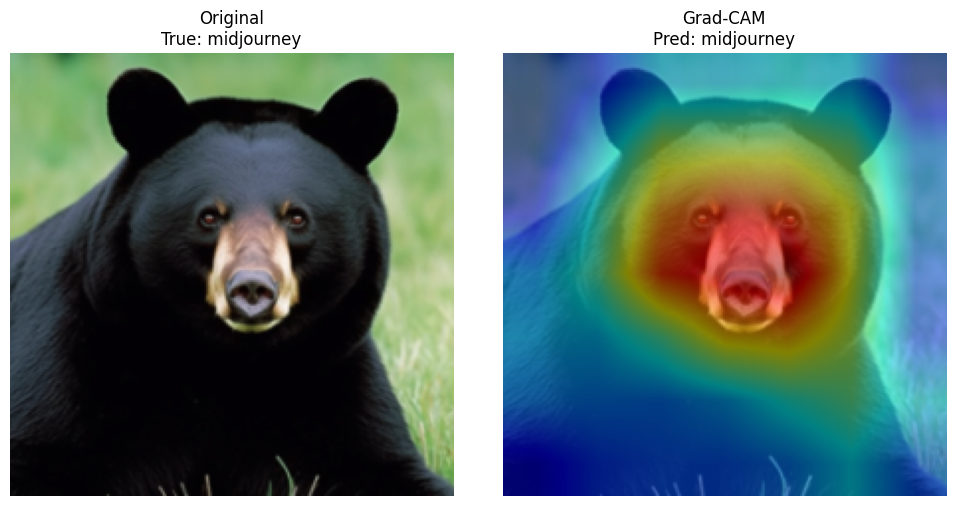

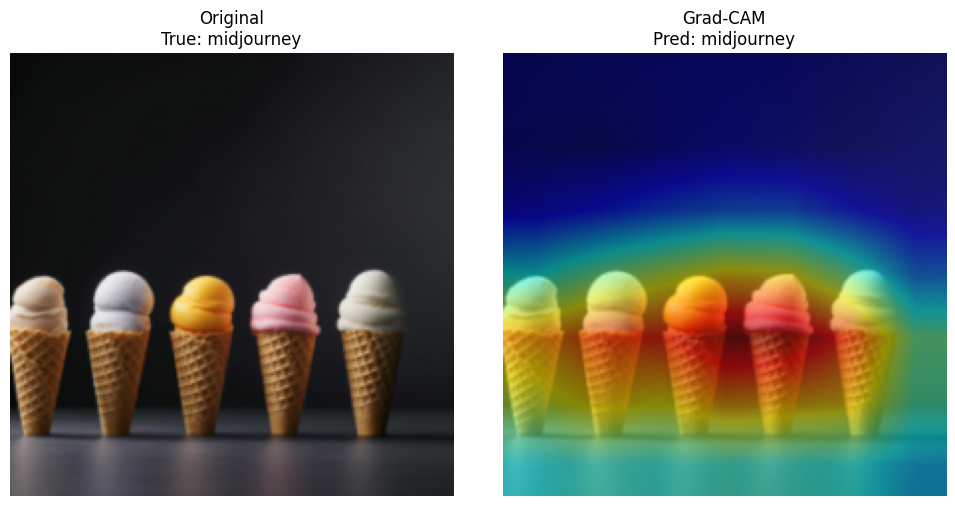

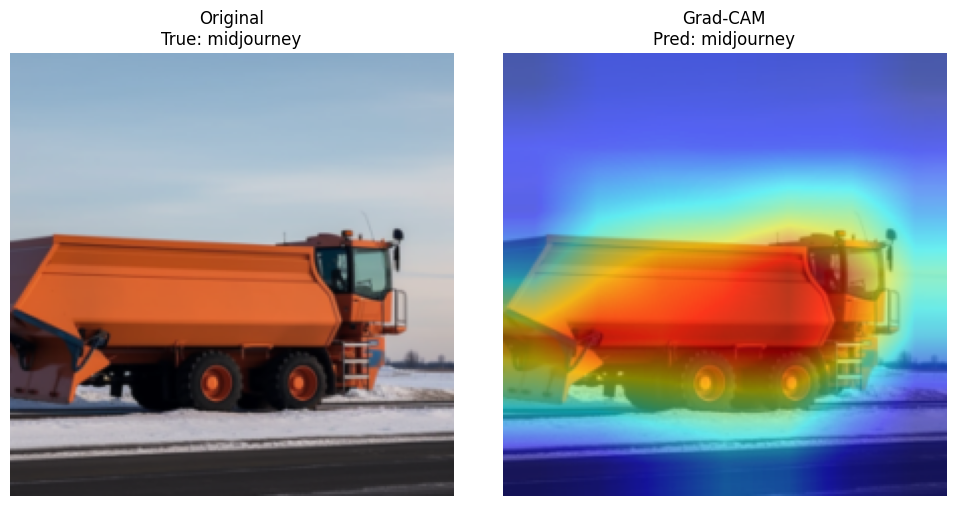

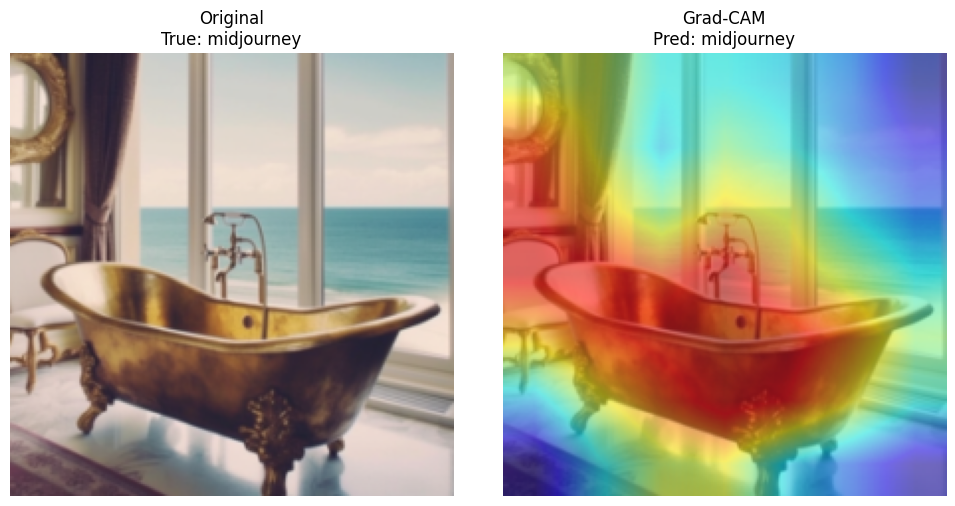

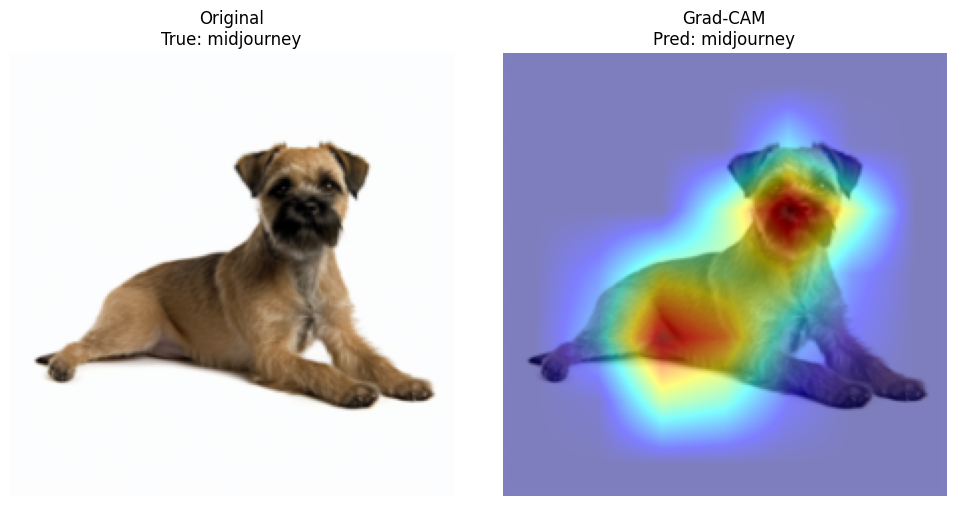

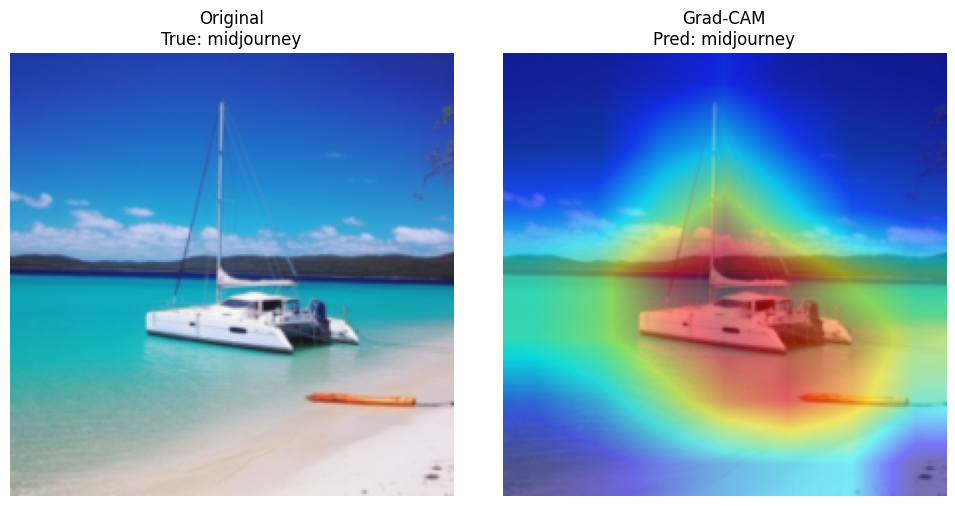

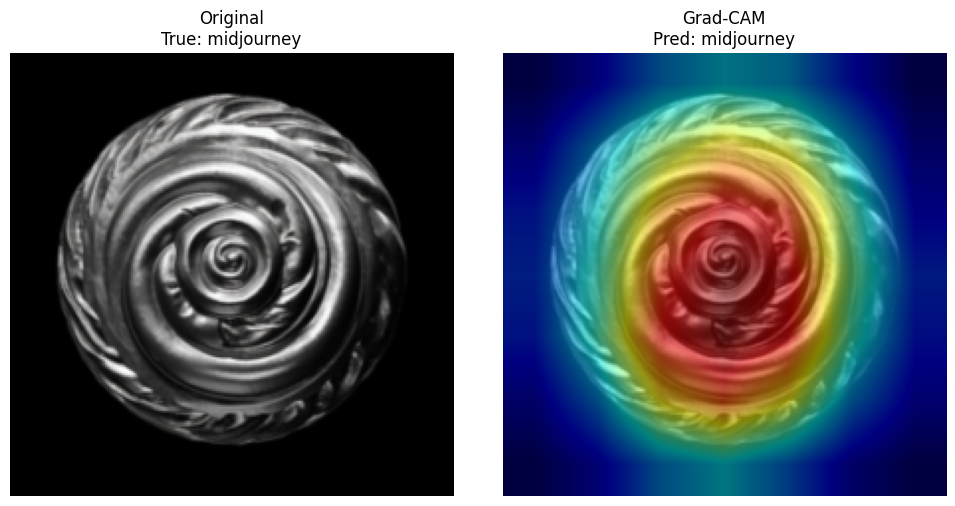

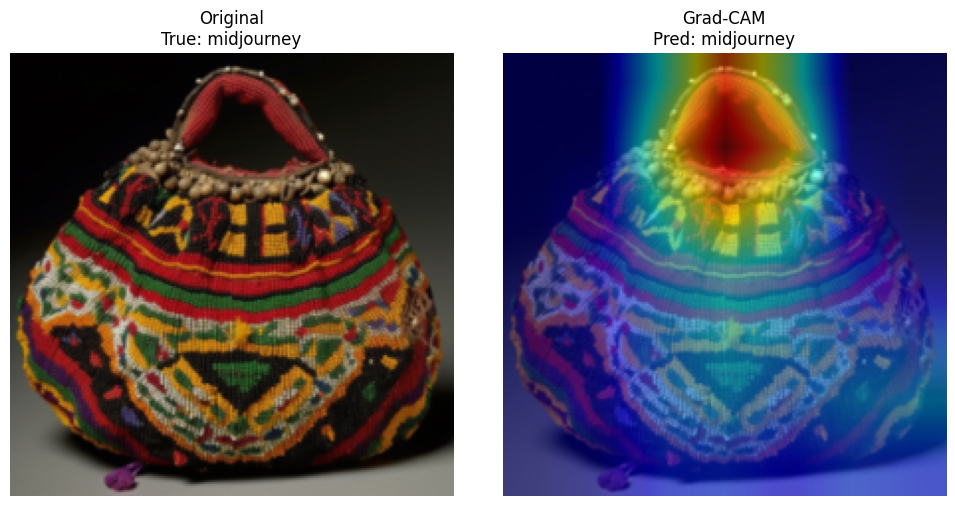

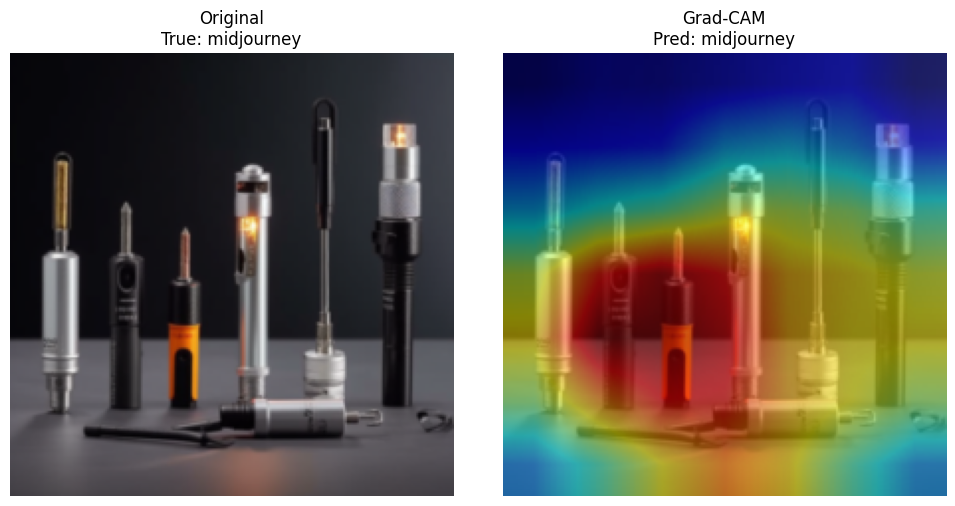

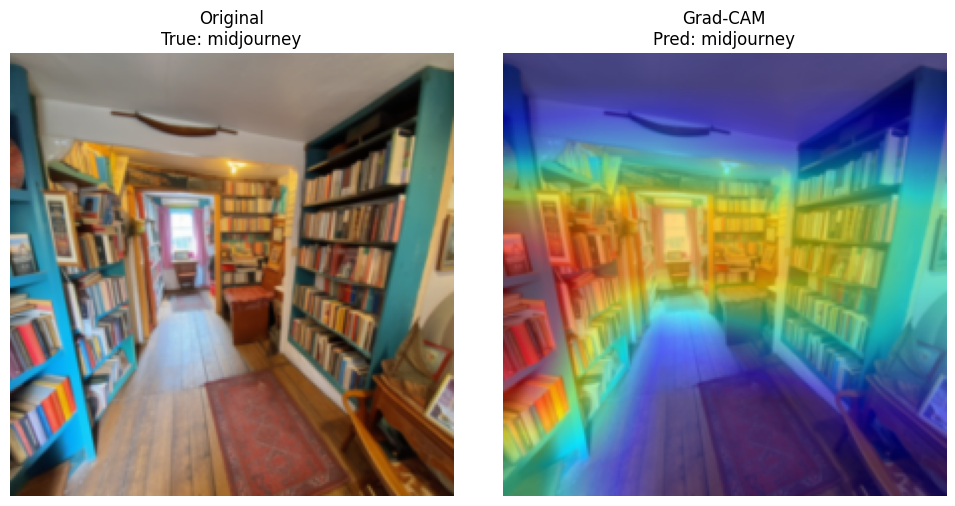

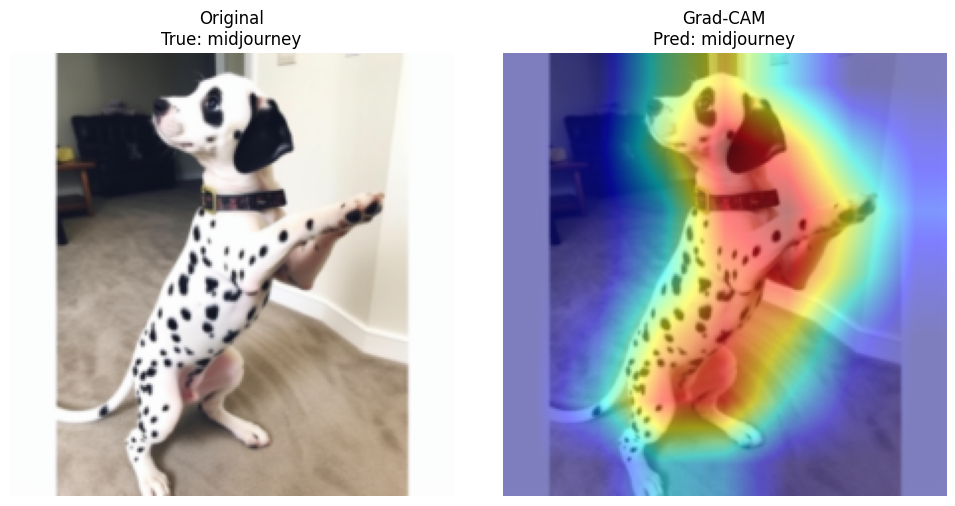

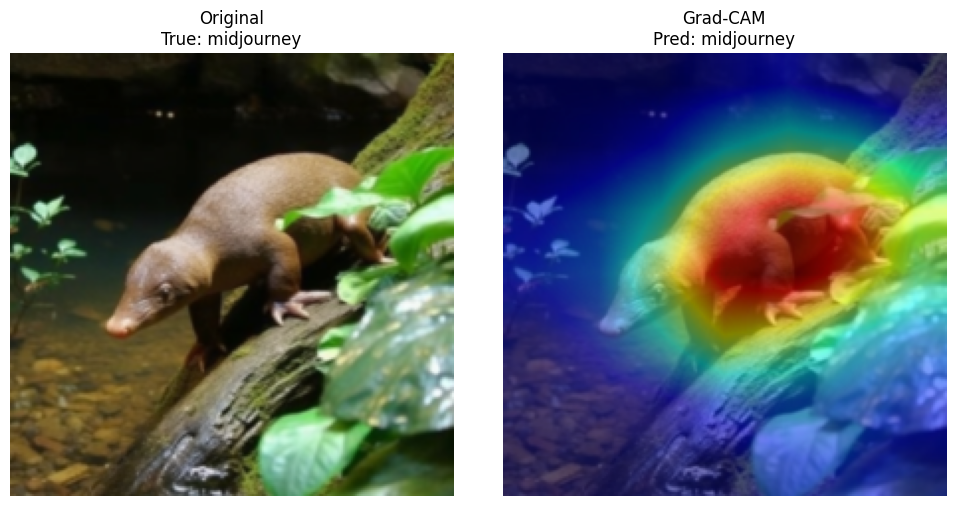

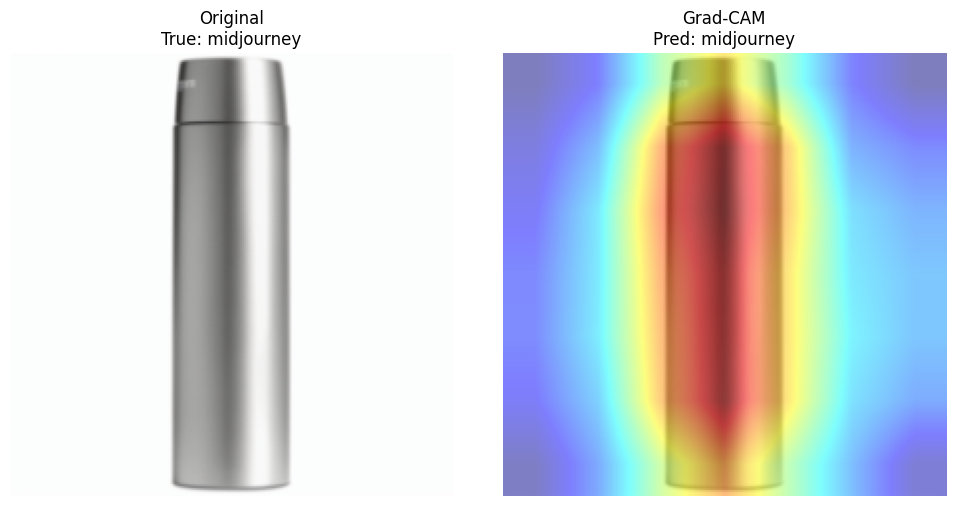

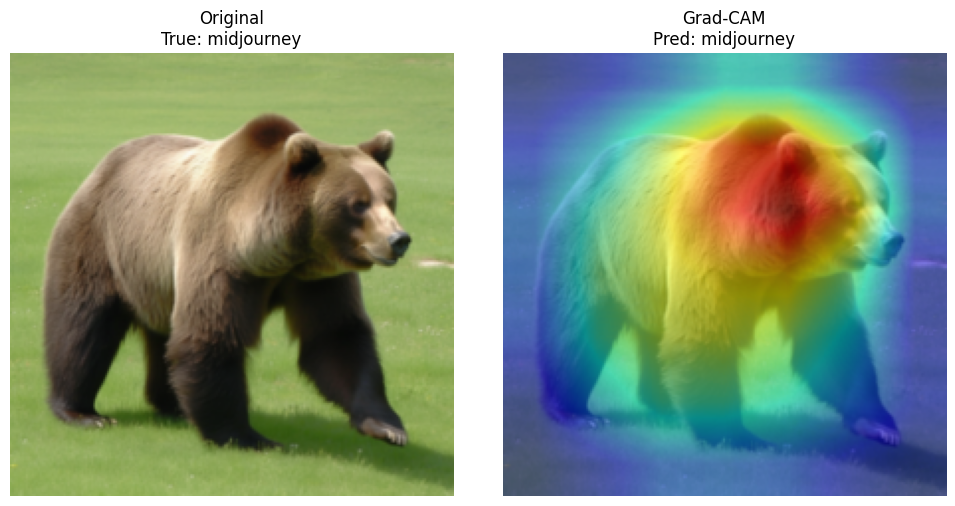

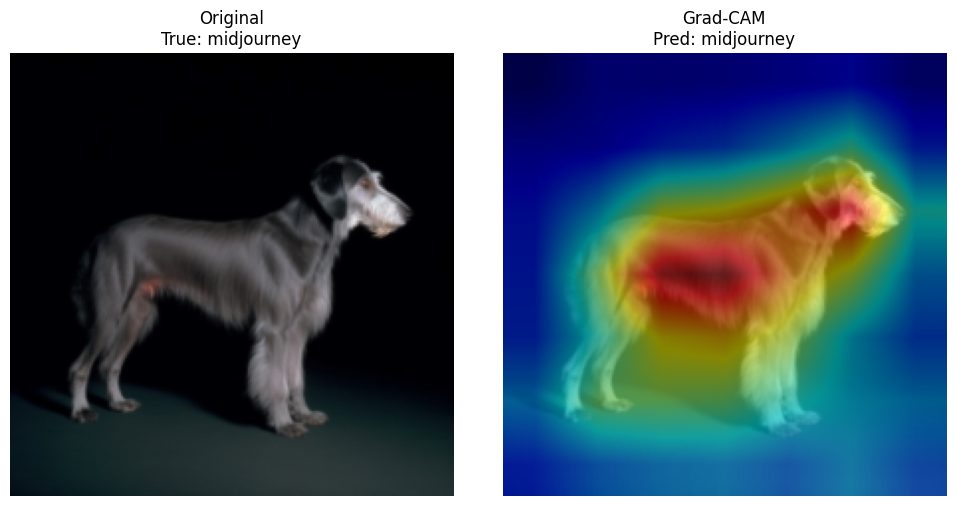

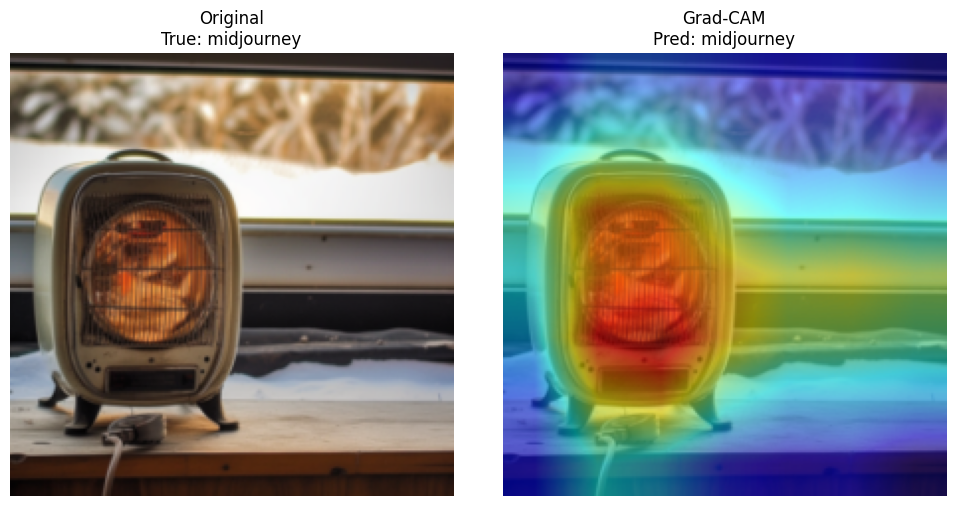

In [8]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
model.classifier[0] = torch.nn.Dropout(p=0.3)

model.load_state_dict(torch.load("models/eficcinet12.pth", map_location=device))
model = model.to(device)
model.eval()

target_layers = [model.features[-1][0]]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = ImageFolder("snicket/data/val", transform=transform)
midjourney_class_idx = val_dataset.class_to_idx["midjourney"]
midjourney_indices = [i for i, (_, label) in enumerate(val_dataset.samples) if label == midjourney_class_idx]
subset_dataset = Subset(val_dataset, midjourney_indices[:20])
subset_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False)

cam = GradCAM(model=model, target_layers=target_layers)
class_names = val_dataset.classes

for i, (img_tensor, label) in enumerate(subset_loader):
    input_tensor = img_tensor.to(device)
    rgb_img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    rgb_img = np.clip(rgb_img, 0, 1)

    output = model(input_tensor)
    pred_class = torch.argmax(output).item()

    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(rgb_img)
    axes[0].set_title(f"Original\nTrue: {class_names[label.item()]}")
    axes[0].axis("off")

    axes[1].imshow(cam_image)
    axes[1].set_title(f"Grad-CAM\nPred: {class_names[pred_class]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
model.classifier[0] = torch.nn.Dropout(p=0.3)
model.load_state_dict(torch.load("models/eficcinet20.pth", map_location=device))
model = model.to(device)
model.eval()

target_layers = [model.features[-1][0]]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder("snicket/data/train", transform=transform)
class_names = train_dataset.classes
midjourney_class_idx = train_dataset.class_to_idx["midjourney"]

# Collect paths for midjourney images only
midjourney_samples = [
    (path, label)
    for path, label in train_dataset.samples
    if label == midjourney_class_idx
]

# Sort by filename and select first 100
midjourney_samples.sort(key=lambda x: os.path.basename(x[0]))
midjourney_samples = midjourney_samples[:100]

class MidjourneySubset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        tensor = self.transform(image)
        return tensor, label, path

subset_dataset = MidjourneySubset(midjourney_samples, transform)
cam = GradCAM(model=model, target_layers=target_layers)

for i in range(len(subset_dataset)):
    img_tensor, label, path = subset_dataset[i]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    rgb_img = np.clip(rgb_img, 0, 1)

    output = model(input_tensor)
    pred_class = torch.argmax(output).item()

    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(rgb_img)
    axes[0].set_title(f"Original\nTrue: {class_names[label]}")
    axes[0].axis("off")

    axes[1].imshow(cam_image)
    axes[1].set_title(f"Grad-CAM\nPred: {class_names[pred_class]}")
    axes[1].axis("off")

    plt.suptitle(os.path.basename(path), fontsize=10)
    plt.tight_layout()
    plt.show()
